### Анализ датасета

Загрузим датасет и посмотрим на его размер

In [17]:
import numpy as np       
import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_excel("Problem1.xlsx", sheet_name = 'Обучение')
print(data.shape)
data.head()

(1750, 10)


,Дата рейса,Откуда,Куда,Продолжительность рейса,ВС,Мест на рейсе,Тип услуги,Доступных мест услуги,"Цена, руб",Фактический спрос
0,2018-03-31,VKO,HKT,> 6 часов,ВС1,522,A,45,1825.0,38
1,2018-03-31,VKO,HKT,> 6 часов,ВС1,522,SU,27,6205.0,23
2,2018-03-31,VKO,HKT,> 6 часов,ВС1,522,S,39,4380.0,18
3,2018-03-31,VKO,PRG,< 3 часов,ВС2,189,F,9,803.0,4
4,2018-03-30,VKO,HKT,> 6 часов,ВС1,522,A,45,1825.0,42


Посмотрим на типы данных и наличии пропусков в таблице

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Дата рейса               1750 non-null   datetime64[ns]
 1   Откуда                   1750 non-null   object        
 2   Куда                     1750 non-null   object        
 3   Продолжительность рейса  1750 non-null   object        
 4   ВС                       1750 non-null   object        
 5   Мест на рейсе            1750 non-null   int64         
 6   Тип услуги               1750 non-null   object        
 7   Доступных мест услуги    1750 non-null   int64         
 8   Цена, руб                1750 non-null   float64       
 9   Фактический спрос        1750 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 136.8+ KB


In [6]:
data.isnull().sum()

Дата рейса                 0
Откуда                     0
Куда                       0
Продолжительность рейса    0
ВС                         0
Мест на рейсе              0
Тип услуги                 0
Доступных мест услуги      0
Цена, руб                  0
Фактический спрос          0
dtype: int64

Найдем уникальные значения категориальных переменных

In [7]:
for index in range(1,data.shape[1]-2):
    print(data.columns[index],':',data.iloc[:,index].unique())

Откуда : ['VKO' 'LED' 'OVB' 'PEE' 'OMS' 'SVX' 'CEK']
Куда : ['HKT' 'PRG' 'PUJ' 'BKK' 'SHJ' 'DXB' 'LCA' 'NBE' 'CFU' 'BCN' 'HER' 'RHO']
Продолжительность рейса : ['> 6 часов' '< 3 часов' 'от 3 до 6 часов']
ВС : ['ВС1' 'ВС2']
Мест на рейсе : [522 189 373 457]
Тип услуги : ['A' 'SU' 'S' 'F' 'C']
Доступных мест услуги : [ 45  27  39   9  36 275  29  21 339  40  47]


#### Дополнительные функции для анализа

Напишем функцию для анализа зависимости между непорядковыми категориальными переменными и численными (ANOVA method)

In [19]:
def comp_df(data, col_num, col_categ):    
    #---create the contingency table---
    df = pd.DataFrame(data, columns=[col_num, col_categ])
    
    uniq = df[col_categ].unique()
    data_comp = pd.DataFrame()
    
    #---form a table where the columns will be categorical features, and the values will be numerical--
    for value in uniq:
        data_uniq = df.loc[df[col_categ] ==  value]
        data_uniq.reset_index(drop=True, inplace=True)
        data_comp[value] = data_uniq[col_num]
    
    #---fill in gaps with median values---
    data_comp = data_comp.fillna(data_comp.median(axis=0), axis=0)
    return data_comp

In [11]:
def f_score_anova(data):
    # number of items in each group
    n = data.shape[0]
    # number of groups
    k = data.shape[1]
    # number of observations
    observation_size = n*k

    # group means and overall mean
    data.loc['Group Means'] = data.mean()
    overall_mean = data.iloc[-1].mean()
    
    # calculate Sum of squares of all observation, SS_total = SS_between + SS_within
    SS_total = (((data.iloc[:-1] - overall_mean)**2).sum()).sum()
    # calculate sum of squares within is the sum of squared deviations of scores around their group’s mean
    SS_within = (((data.iloc[:-1] - data.iloc[-1])**2).sum()).sum()
    # calculate the sum of squares of the group means from the overall mean:
    SS_between = (n * (data.iloc[-1] - overall_mean)**2).sum()

    # compute the various degrees of freedoms
    df_total = observation_size - 1       
    df_within = observation_size - k      
    df_between = k - 1
    print('df1 between =', df_between)
    print('df2 within =', df_within)
    
    # compute the various mean squared values
    mean_sq_between = SS_between / (k - 1)
    mean_sq_within = SS_within / (observation_size - k)

    # calculate the F-value, which is the ratio of two variances
    F = mean_sq_between / mean_sq_within

    return F

#### Анализ категориальных перменных с target

Введем новую переменную Относительный спрос = Фактический спрос/Доступных мест услуги - эта переменная и будет нашим target, который впоследствии будем предсказывать.

In [8]:
data['Относительный спрос']=data['Фактический спрос']/data['Доступных мест услуги']

В первую очередь посмотри как связаны Относительный спрос и Тип услуги

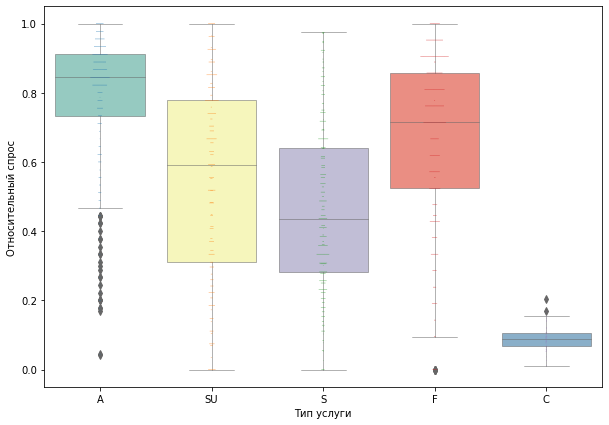

In [10]:
plt.figure(figsize=(10,7))
sns.boxplot(x="Тип услуги", y="Относительный спрос", data=data, palette="Set3", linewidth=0.5)
sns.swarmplot(x="Тип услуги", y="Относительный спрос", data=data, size=0.5)
plt.show()

Видим, что для каждого Типа услуги есть преобладание в тут или иную область Относительного спроса

Однако, посмотрим также на количество имеющихся в датасете Типов услуг

<AxesSubplot:>

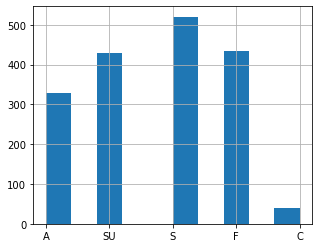

In [16]:
data['Тип услуги'].hist(bins=10 , figsize=(5,4))

Отметим, что по услуге "С" данных значительно меньше.  
Теперь посмотрим на статистическую значимость рассматриваемой зависимости с помощью метода ANOVA

In [20]:
data_comp = comp_df(data,'Относительный спрос','Тип услуги')
F = f_score_anova(data_comp)
print('F = ', '%.2f' % F)

# Также проверим F-score с помощью функции из библиотеки stats
fvalue, pvalue = stats.f_oneway(*data_comp.iloc[:-1,0:5].T.values)
print('F (Stats module)=','%.2f' % fvalue, 'p-value (Stats module)', pvalue)

df1 between = 4
df2 within = 1640
F =  525.95
F (Stats module)= 525.95 p-value (Stats module) 5.23333923722473e-292


Итак, наша зависимость статистически значима, поэтому оставим данную категориальную переменную для обучения модели*

Теперь посмотрим на остальные категориальные переменные:

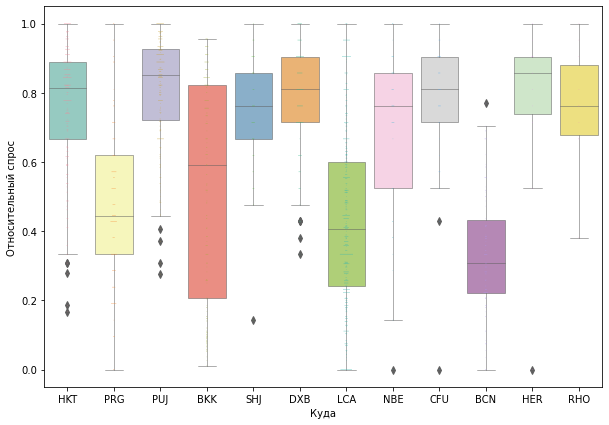

In [21]:
plt.figure(figsize=(10,7))
sns.boxplot(x="Куда", y="Относительный спрос", data=data, palette="Set3", linewidth=0.5)
sns.swarmplot(x="Куда", y="Относительный спрос", data=data, size=0.5)
plt.show()

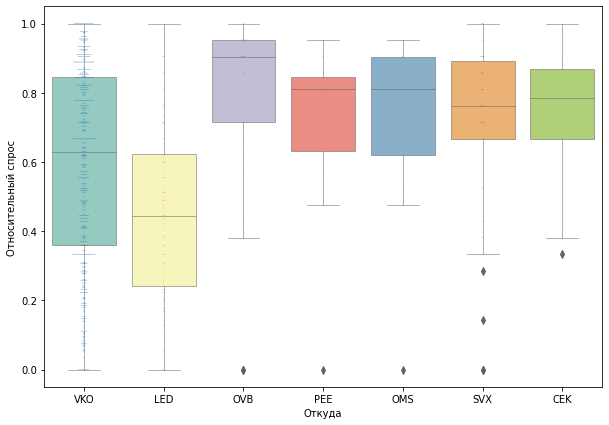

In [22]:
plt.figure(figsize=(10,7))
sns.boxplot(x="Откуда", y="Относительный спрос", data=data, palette="Set3", linewidth=0.5)
sns.swarmplot(x="Откуда", y="Относительный спрос", data=data, size=0.5)
plt.show()

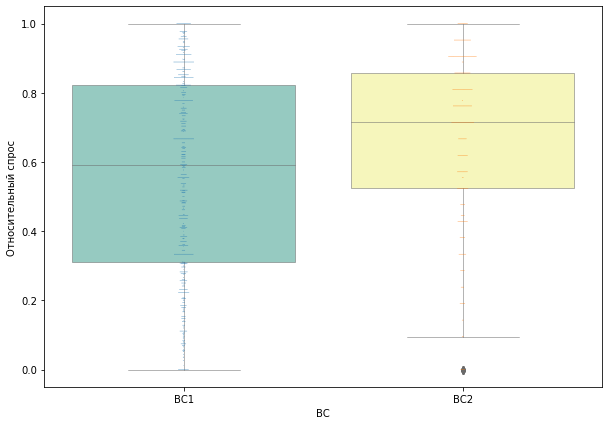

In [25]:
plt.figure(figsize=(10,7))
sns.boxplot(x="ВС", y="Относительный спрос", data=data, palette="Set3", linewidth=0.5)
sns.swarmplot(x="ВС", y="Относительный спрос", data=data, size=0.5)
plt.show()

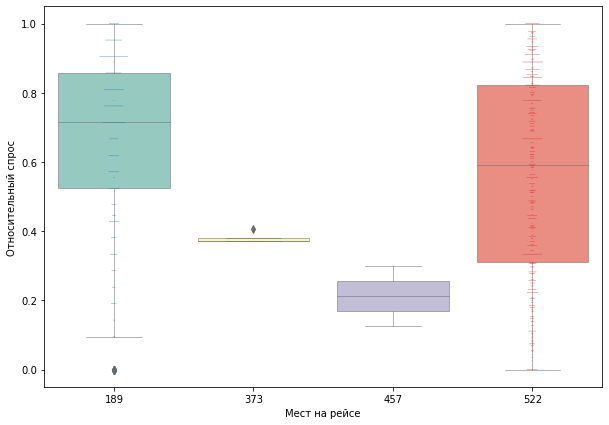

In [26]:
plt.figure(figsize=(10,7))
sns.boxplot(x="Мест на рейсе", y="Относительный спрос", data=data, palette="Set3", linewidth=0.5)
sns.swarmplot(x="Мест на рейсе", y="Относительный спрос", data=data, size=0.5)
plt.show()

Обратим внимание, что переменная ВС практически однозначно описывает количество Мест на рейсе (с некоторыми исключениями см. ниже), поэтому для обучения оставим только одну переменную ВС

In [34]:
data.groupby(['Мест на рейсе'])[['ВС'] ].agg(['count'])

,ВС
,count
Мест на рейсе,
189,434
373,4
457,2
522,1310


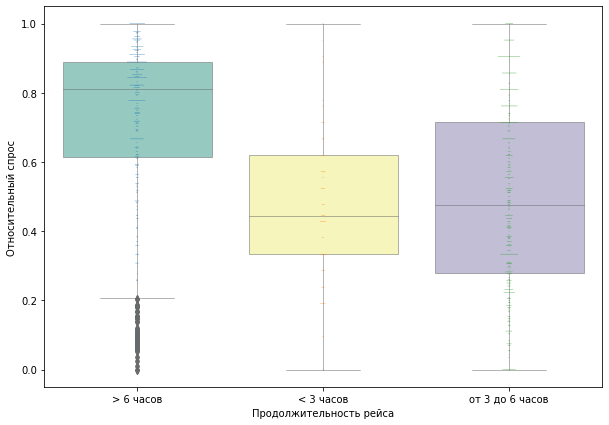

In [27]:
plt.figure(figsize=(10,7))
sns.boxplot(x="Продолжительность рейса", y="Относительный спрос", data=data, palette="Set3", linewidth=0.5)
sns.swarmplot(x="Продолжительность рейса", y="Относительный спрос", data=data, size=0.5)
plt.show()

Из указанных выше переменных оставим для обучения те, по которым видна зависимость: Продолжительность рейса и ВС. Перменные Откуда и Куда не показывают значительные зависимости с target и имеют значительное количество уникальных значений, что вызовет большое количество столбцов при one-hot кодировании, поэтому их в модель включать не будем.

#### Анализ количественных перменных с target

Посмотрим на корреляцию targer с Ценой

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


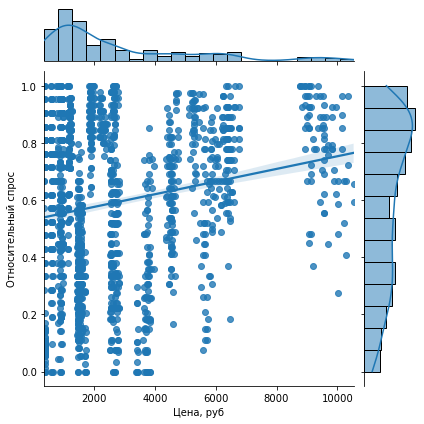

In [36]:
sns.jointplot("Цена, руб", "Относительный спрос", data=data, kind='reg');

In [37]:
data[['Цена, руб', 'Относительный спрос']].corr(method='pearson')

,"Цена, руб",Относительный спрос
"Цена, руб",1.000000,0.184154
Относительный спрос,0.184154,1.000000


Видим, что небольшая корреляция есть, поэтому данный параметр также оставим для обучения модели

#### Анализ связи даты с target

В первую очередь посмотрим на месяца и наличие сезонности

In [38]:
data['Месяц рейса'] = data['Дата рейса'].apply(lambda x: x.month_name())

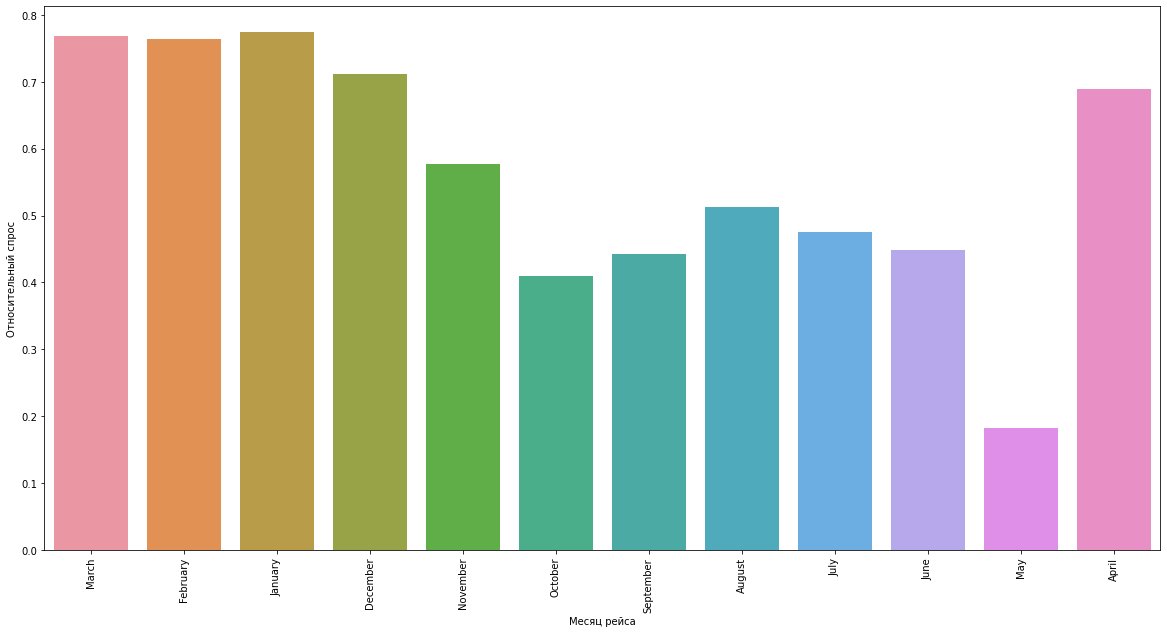

In [39]:
plt.figure(figsize=(20,10))
c_date_plot = sns.barplot(x='Месяц рейса', y='Относительный спрос', data=data[data['Тип услуги']=='SU'], ci=None)
c_date_plot.set_xticklabels(c_date_plot.get_xticklabels(),rotation=90);

Видим, что наблюдается рост Относительного спроса от Мая к Апрелю, поэтому данный признак выделим как отдельный для обучения

<AxesSubplot:>

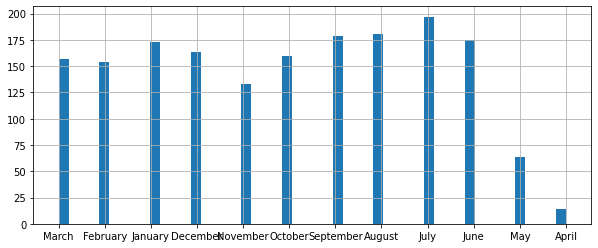

In [42]:
data['Месяц рейса'].hist(bins=50 , figsize=(10,4))

Теперь посмотрим в целом на зависимость Даты и Относительного спроса

In [62]:
dates = pd.DataFrame()
dates['dates'] = data['Дата рейса'].apply(lambda x: x.date())
dates['Относительный спрос'] = data['Относительный спрос']
dates

,dates,Относительный спрос
0,2018-03-31,0.844444
1,2018-03-31,0.851852
2,2018-03-31,0.461538
3,2018-03-31,0.444444
4,2018-03-30,0.933333
...,...,...
1745,2016-10-02,0.148148
1746,2016-10-01,0.000000
1747,2016-10-01,0.000000
1748,2016-10-01,0.000000


In [63]:
dates['dates'] = data['Дата рейса'].apply(lambda x: x.date())

dates = dates.sort_values(by = 'dates')
# запишем самую первую дату датасета
min_date = dates.iloc[0][0]

# посчитаем количество прошедших дней с данной даты
dates['Day from date'] = dates['dates'] - min_date

In [64]:
# скорректируем, чтобы остался только int
dates['Day from date']=dates['Day from date'].map(lambda x: str(x)[:-14])
dates['Day from date'] = dates['Day from date'].astype(int)

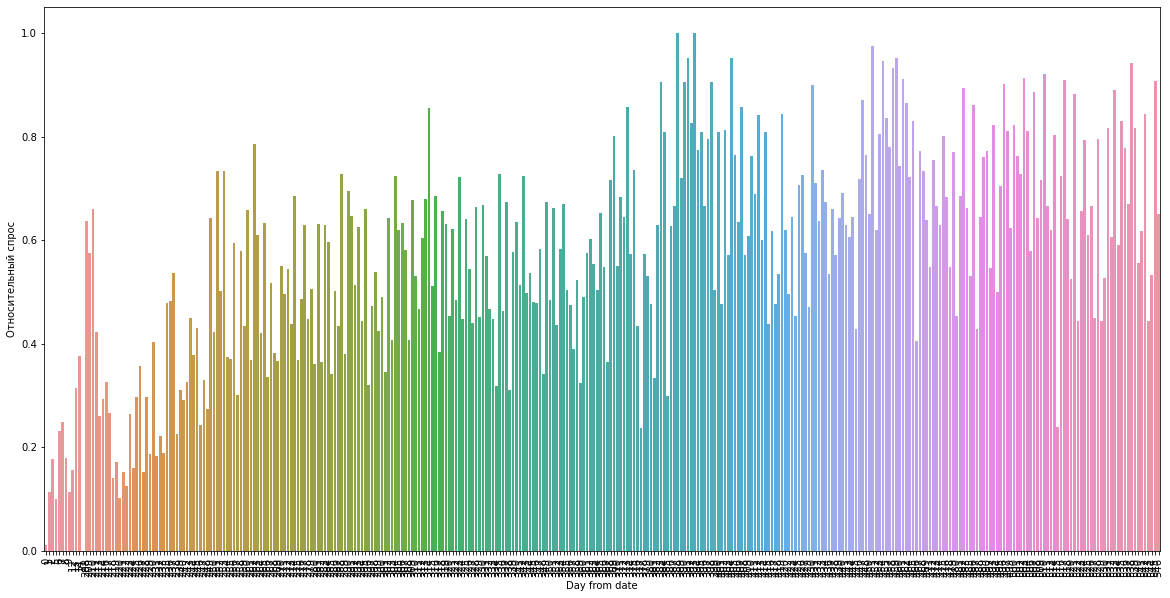

In [65]:
plt.figure(figsize=(20,10))
c_date_plot = sns.barplot(x='Day from date', y='Относительный спрос', data=dates, ci=None)
c_date_plot.set_xticklabels(c_date_plot.get_xticklabels(),rotation=90);

По графику видно, что наблюдается рост Относительного спроса со временем, поэтому данный параметр оставим для обучения

In [66]:
dates[['Day from date', 'Относительный спрос']].corr(method='pearson')

,Day from date,Относительный спрос
Day from date,1.000000,0.393378
Относительный спрос,0.393378,1.000000


Зависимость также видно и по коэффициенту корреляции выше

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


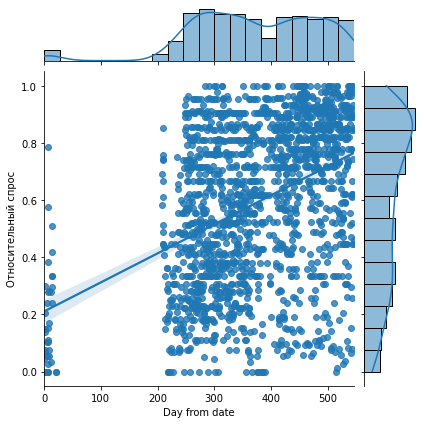

In [67]:
sns.jointplot("Day from date", "Относительный спрос", data=dates, kind='reg');

<AxesSubplot:>

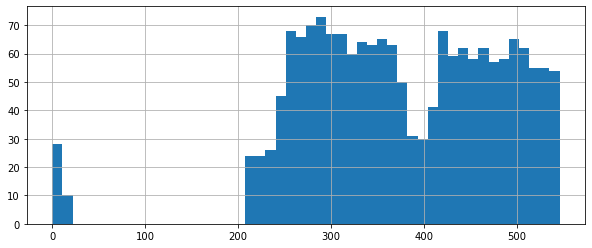

In [68]:
dates['Day from date'].hist(bins=50 , figsize=(10,4))

Отметим, что мы увидели разрыв в данных, т.е. с октября 2016 года по апрель 2017 года у нас нет информации 

Поэтому посмотрим еще раз на зависимость начиная с апреля 2017 года

In [71]:
dates_200 = dates[dates['Day from date']>200]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


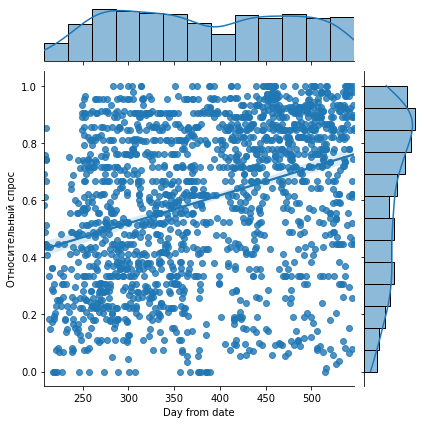

In [74]:
sns.jointplot("Day from date", "Относительный спрос", data=dates_200, kind='reg');

In [76]:
dates_200[['Day from date', 'Относительный спрос']].corr(method='pearson')

,Day from date,Относительный спрос
Day from date,1.000000,0.336662
Относительный спрос,0.336662,1.000000


Видим, что коэффициент корреляции стал меньше, но линейная зависимость все еще наблюдается